## Introduce what the project is about and how it is connected to the Data Science
- List key goals for project and the ones that were achieved during the project
- Discuss the work you did on this project and include any tools used
- Show a brief demo of the working software, if any development was done
- Presentation between 10-15 minutes (each team member highlighting their work
and participate in the presentation)


## Jeff (5 mins)

- Data Set Overview
- Visualizations
- Introduce project goal
    - Train a model and make predictions on cloud infrastructure
- Modeling
    - Naive Bayes
    - Decision Tree
    - Speed/ Model Size vs Accuracy

## Chance (5 mins)

- Serverless Framework 
    - Serverless Process Flow
    - YAML (Blueprint)
- Local Setup and Validation
- Docker
    - Slim option (workaround for Lambda file size limitations)
- Deployment
    - DEV/ PROD
- Cloud Formation Code 
    - API Gateway
    - Lambda

## Sreeni (5 mins)

- RDS Integration
- Security Manager
    - password retrieval within deployed code
- RDS Proxy (not implemented, but could expand on the benefits)
- API Gateway Security ((not implemented, but could expand on the benefits))
    - IAM-based authorization
    - User Pool Authorizers 

https://www.youtube.com/watch?v=AV24RTvbgWA

# Introduction

Wildfires have broken out all over the western region of the United States in 2020, devastating communities and
creating smoke plumes that can be seen even from space via satellite images. Some billows of smoke have carried
over to places as far away as London, and it has been said that cities such as San Francisco and Seattle have
some of the lowest quality of air on the entire planet currently due to the fires.
As one of us lives close to the Bobcat Fire in California, which has currently burned over 93 thousand acres of land,
the team thought it would be an interesting topic to delve into the data that has been collected in this domain over
the past quarter century or so to mine any insights.

# US Wildfires Data Set

** PLACEHOLDER DESCRIPTION FROM KAGGLE COMPETION **

"_This data publication contains a spatial database of wildfires that occurred in the United States from 1992 to 2015. It is the third update of a publication originally generated to support the national Fire Program Analysis (FPA) system. The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). The data were transformed to conform, when possible, to the data standards of the National Wildfire Coordinating Group (NWCG). Basic error-checking was performed and redundant records were identified and removed, to the degree possible. The resulting product, referred to as the Fire Program Analysis fire-occurrence database (FPA FOD), includes 1.88 million geo-referenced wildfire records, representing a total of 140 million acres burned during the 24-year period._" 

(https://www.kaggle.com/rtatman/188-million-us-wildfires)

# Objective One

## Question of Interest

Given the size, location, date and other relevant features from the dataset, can we predict the cause of a wildfire?


### Exploratory Data Analysis

#### Library Imports

In [1]:
# Base Imports
import sqlite3
import pandas as pd
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Pre-processing
from sklearn.preprocessing import LabelEncoder

# Metrics and Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Pipeline
from sklearn.pipeline import Pipeline
import joblib

# Estimators
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#### Set Training Parameters

In [2]:
estimator = "decision_tree_classifier"
train_model = False

#### Load Data

In [3]:
%%time
conn = sqlite3.connect('../../../data/FPA_FOD_20170508.sqlite')
df_fires = pd.read_sql_query("SELECT * FROM 'Fires'", conn)


Wall time: 31.2 s


In [4]:
df_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

In [5]:
%%time

df_fires.set_index("OBJECTID", inplace=True)

Wall time: 20 ms


#### Missing Values

In [6]:
df_fires.isna().any()

FOD_ID                        False
FPA_ID                        False
SOURCE_SYSTEM_TYPE            False
SOURCE_SYSTEM                 False
NWCG_REPORTING_AGENCY         False
NWCG_REPORTING_UNIT_ID        False
NWCG_REPORTING_UNIT_NAME      False
SOURCE_REPORTING_UNIT         False
SOURCE_REPORTING_UNIT_NAME    False
LOCAL_FIRE_REPORT_ID           True
LOCAL_INCIDENT_ID              True
FIRE_CODE                      True
FIRE_NAME                      True
ICS_209_INCIDENT_NUMBER        True
ICS_209_NAME                   True
MTBS_ID                        True
MTBS_FIRE_NAME                 True
COMPLEX_NAME                   True
FIRE_YEAR                     False
DISCOVERY_DATE                False
DISCOVERY_DOY                 False
DISCOVERY_TIME                 True
STAT_CAUSE_CODE               False
STAT_CAUSE_DESCR              False
CONT_DATE                      True
CONT_DOY                       True
CONT_TIME                      True
FIRE_SIZE                   

#### Total US Wildfires by Cause


Across all of the states included in the dataset, **debris burning** was the category identified as having caused the most wildfires.  The lables are obviously very skewed, so this may need to be taken into account when building our final prediction model.  A technique like **SMOTE** might be of use so that the categories with the lower samples are artificially upsampled to match that of the hightest one.

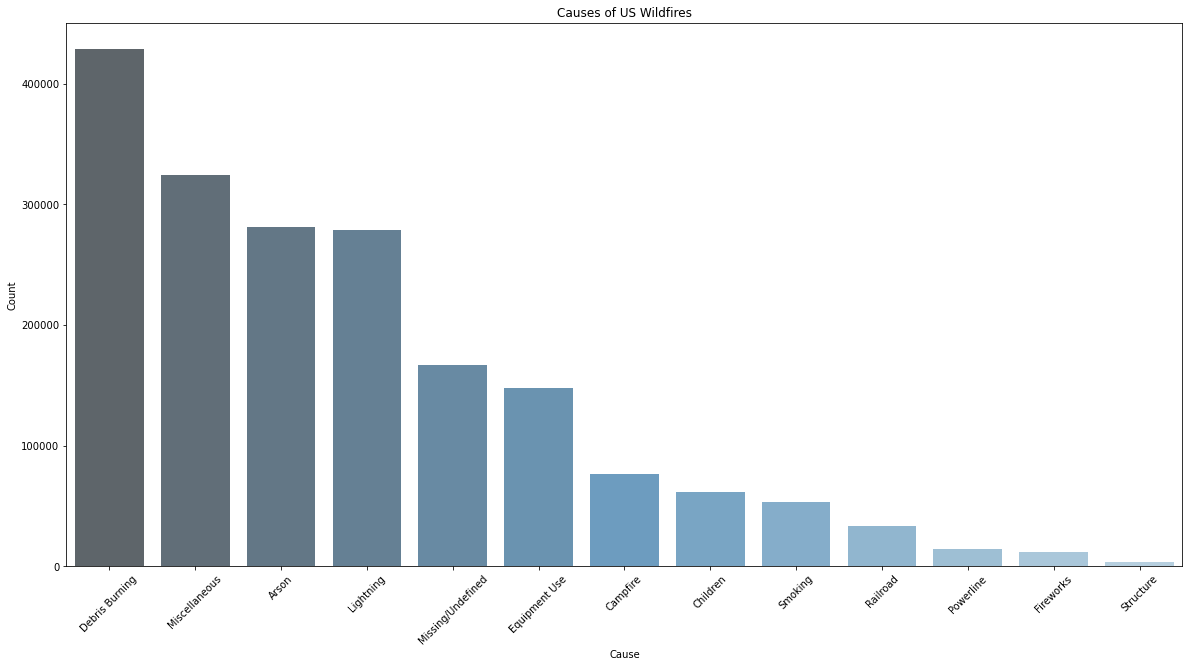

In [7]:
fig_0 = plt.figure(1, figsize=(20, 10))

chart_1 = fig_0.add_subplot(111)

cause_count  = df_fires['STAT_CAUSE_DESCR'].value_counts()

sns.barplot(cause_count.index, cause_count.values, alpha=0.8, palette="Blues_d")
chart_1.set_title('Causes of US Wildfires')
chart_1.set_xlabel('Cause')
chart_1.set_ylabel('Count')
chart_1.set_xticklabels(chart_1.get_xticklabels(), rotation=45)

plt.show()

#### Total US Wildfires by Year

The dataset includes wildfires that occurred in the United States from **1992** to **2015**.

#### Converting Julian to calendar date using pandas

 - https://stackoverflow.com/questions/63434276/converting-julian-to-calendar-date-using-pandas

In [8]:
df_fires["DISCOVERY_DATETIME"] = pd.to_datetime(df_fires["DISCOVERY_DATE"], unit='D', origin='julian')
df_fires['DISCOVERY_DAY_OF_WEEK'] = df_fires["DISCOVERY_DATETIME"].dt.day_name()

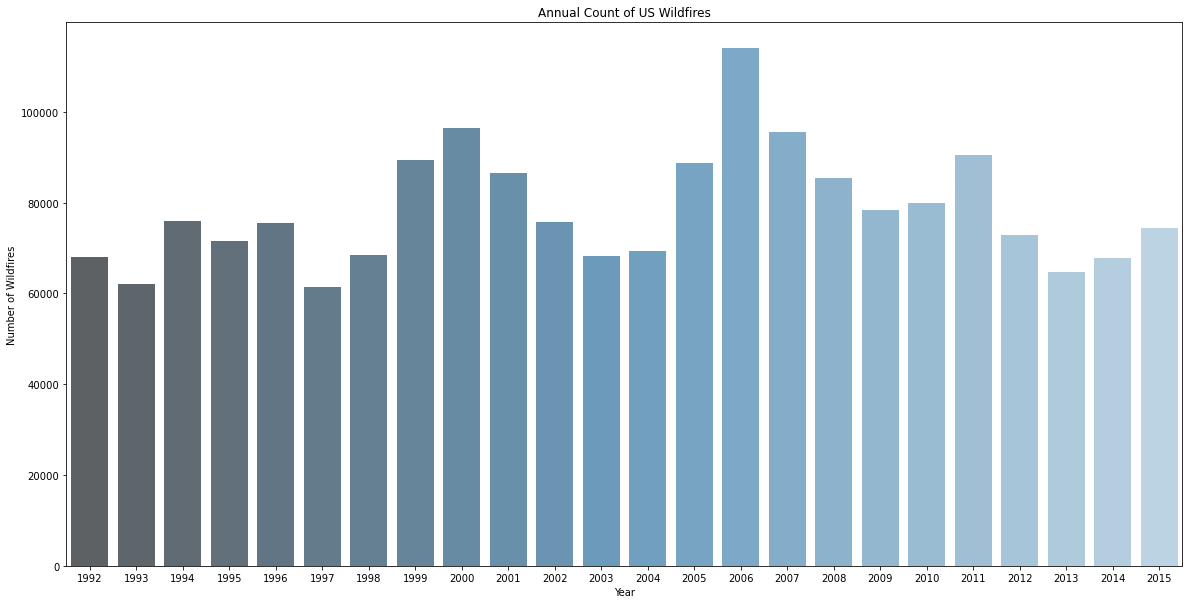

In [9]:
year_count  = df_fires['FIRE_YEAR'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
sns.barplot(year_count.index, year_count.values, alpha=0.8, palette="Blues_d")
plt.title('Annual Count of US Wildfires')
plt.ylabel('Number of Wildfires')
plt.xlabel('Year')
plt.show()

#### Total US Wildfires by State

California, Georgia and Texas have the highest volume of recorded wildfires.  California has the highest population of any state in the union, followed by a distant second with Texas.  The counts for those states could be somewhat expected in that they have higher populations.  The counts for Georgia however do seem a bit high considering that their state population is lower on the list of most populated states.  Further investigation might be warranted there.  We may also look to see if states differ in their category rankings.

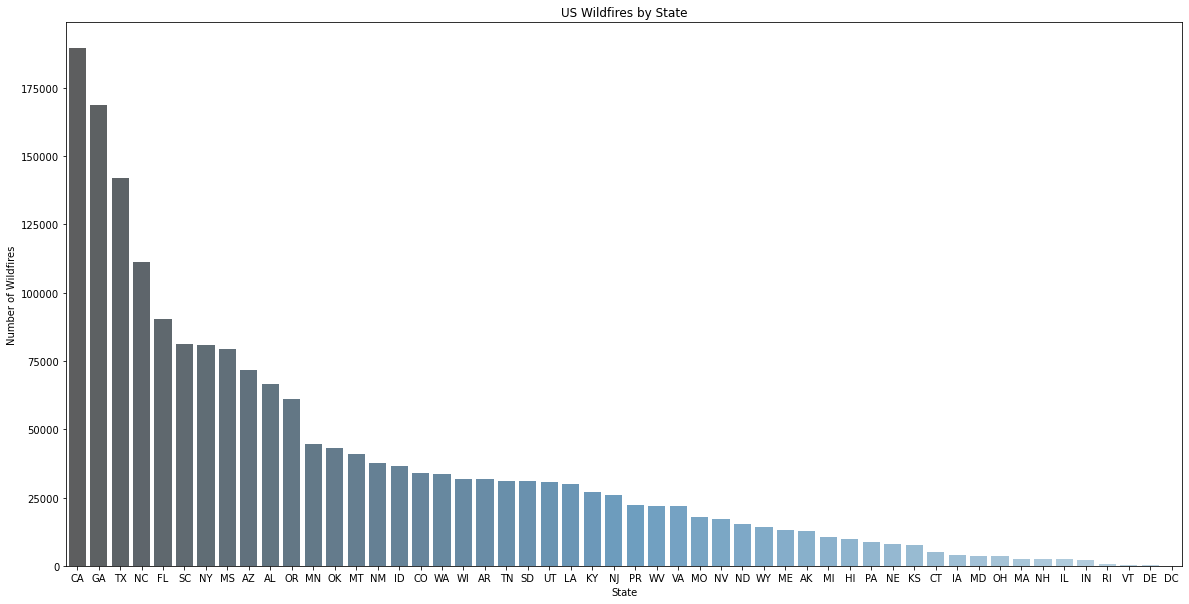

In [10]:
state_count  = df_fires['STATE'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(state_count.index, state_count.values, alpha=0.8, palette="Blues_d")
plt.title('US Wildfires by State')
plt.ylabel('Number of Wildfires')
plt.xlabel('State')
plt.show()


## Modeling


- Naive Bayes

- Decision Tree

In [11]:
# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# map to numerical values in a new variable
df_fires["STATE_CAT"] = label_encoder.fit_transform(df_fires['STATE'])
df_fires["OWNER_DESCR_CAT"] = label_encoder.fit_transform(df_fires['OWNER_DESCR'])
df_fires["DISCOVERY_DAY_OF_WEEK_CAT"] = label_encoder.fit_transform(df_fires['DISCOVERY_DAY_OF_WEEK'])

In [12]:
X = df_fires[["LATITUDE", "LONGITUDE", "DISCOVERY_DATE", "FIRE_SIZE", "STATE_CAT", "OWNER_DESCR_CAT", "DISCOVERY_DAY_OF_WEEK_CAT"]]
y = df_fires["STAT_CAUSE_DESCR"]

### Train / Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.1, 
    random_state=1, 
    stratify=y)

### Train Gaussian Naive Bayes Classifier

In [14]:
%%time

if train_model and estimator == "gaussian_nb":
    
    clf = OneVsRestClassifier(GaussianNB())

    clf.fit(X_train, y_train)

Wall time: 0 ns


### Train Decision Tree Classifier

In [15]:
%%time

if train_model and estimator == "decision_tree_classifier":

    clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=1, 
        splitter='best', 
        min_samples_split=5, 
        min_samples_leaf=4, 
        max_features='auto', 
        class_weight=None))

    clf.fit(X_train, y_train)

Wall time: 0 ns


In [16]:
if train_model and estimator == "decision_tree_classifier":
    joblib.dump(clf, './aws_predict/training/models/decission_tree_classifier.pkl', compress=3)
elif train_model and estimator == "gaussian_nb":
    joblib.dump(clf, './aws_predict/training/models/gaussian_nb_classifier.pkl')
else:
    pass   

### Predictions

Once the model has been defined, predictions can be made on new and unseen data. 

#### Gaussian Naive Bayes Classifier

In [17]:
nb_clf = joblib.load('./aws_predict/training/models/gaussian_nb_classifier.pkl') 

pred_test = [[43.235833, -122.466944, 2452859.5, 0.1, 37, 15, 0]]

nb_clf.predict(pred_test)

array(['Lightning'], dtype='<U17')

In [18]:
%%time

y_pred = nb_clf.predict(X_test)

Wall time: 869 ms


In [19]:
%%time

print ('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.31547964072811585
Wall time: 442 ms


In [20]:
%%time

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

            Arson       0.52      0.01      0.02     28145
         Campfire       0.00      0.00      0.00      7614
         Children       0.08      0.14      0.10      6117
   Debris Burning       0.29      0.90      0.44     42903
    Equipment Use       0.36      0.10      0.15     14761
        Fireworks       0.09      0.37      0.14      1150
        Lightning       0.63      0.43      0.51     27847
    Miscellaneous       0.25      0.09      0.13     32381
Missing/Undefined       0.75      0.19      0.31     16672
        Powerline       0.00      0.00      0.00      1445
         Railroad       0.00      0.00      0.00      3345
          Smoking       0.00      0.00      0.00      5287
        Structure       0.00      0.00      0.00       380

         accuracy                           0.32    188047
        macro avg       0.23      0.17      0.14    188047
     weighted avg       0.38      0.32      0.24    18

#### Decision Tree Classifier

In [21]:
dt_clf = joblib.load('./aws_predict/training/models/decission_tree_classifier.pkl') 

pred_test = [[43.235833, -122.466944, 2452859.5, 0.1, 37, 15, 0]]

dt_clf.predict(pred_test)

array(['Lightning'], dtype='<U17')

In [22]:
%%time

y_pred = dt_clf.predict(X_test)

Wall time: 816 ms


In [23]:
%%time

print ('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.5223640898286067
Wall time: 467 ms


In [24]:
%%time

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

            Arson       0.51      0.48      0.50     28145
         Campfire       0.39      0.28      0.33      7614
         Children       0.24      0.16      0.19      6117
   Debris Burning       0.51      0.56      0.53     42903
    Equipment Use       0.31      0.27      0.29     14761
        Fireworks       0.37      0.31      0.34      1150
        Lightning       0.70      0.75      0.72     27847
    Miscellaneous       0.47      0.49      0.48     32381
Missing/Undefined       0.88      0.89      0.88     16672
        Powerline       0.15      0.12      0.13      1445
         Railroad       0.40      0.40      0.40      3345
          Smoking       0.13      0.09      0.10      5287
        Structure       0.01      0.07      0.02       380

         accuracy                           0.52    188047
        macro avg       0.39      0.37      0.38    188047
     weighted avg       0.52      0.52      0.52    18

# Objective Two

Now that a model has been defined, can we make use of cloud resources to make predictions?

## Cloud Deployment

- Serverless Framework
    - Local Setup and Validation
        - YAML (Blueprint)
        - Dependencies
        - ZIP File Size Reduction
        - Stages (DEV, QA, PROD deployment)
    - API Gateway
    - Lambda
    - RDS


### AWS Serverless Process Flow

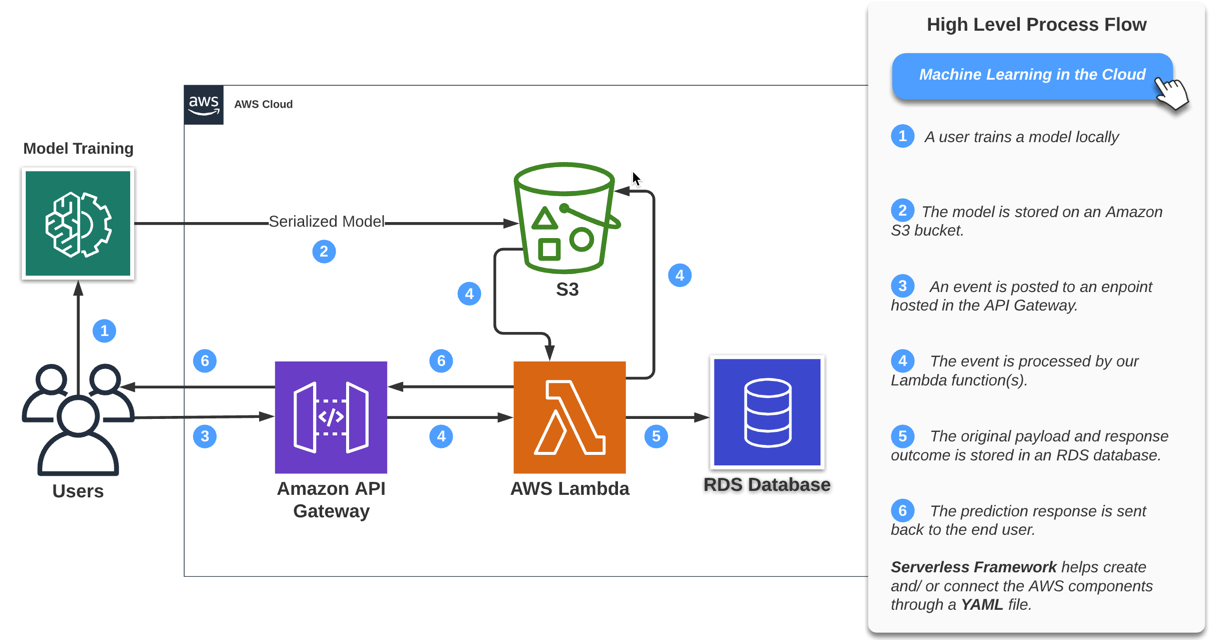

In [25]:
Image(filename='./img/aws_serverless_prediction_flow.png') 

### Local Setup and Validation

The `sls invoke local` command can be used to validate that your function is working properly.

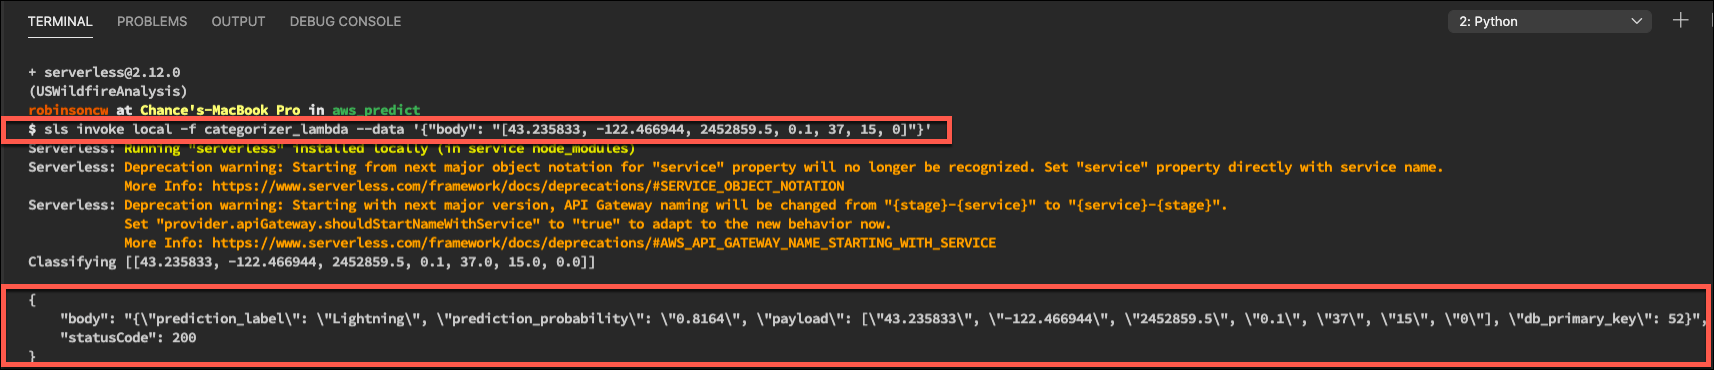

In [26]:
Image(filename='./img/sls_predictions.png') 

###  Serverless Deployment

Environments can be staged so that build can be performed in a non-production instance that won't impact your active service.

- `serverless deploy --stage=dev`

Assets can also be removed with a single command, removing all artifacts created by the deployment.

- `serverless remove`

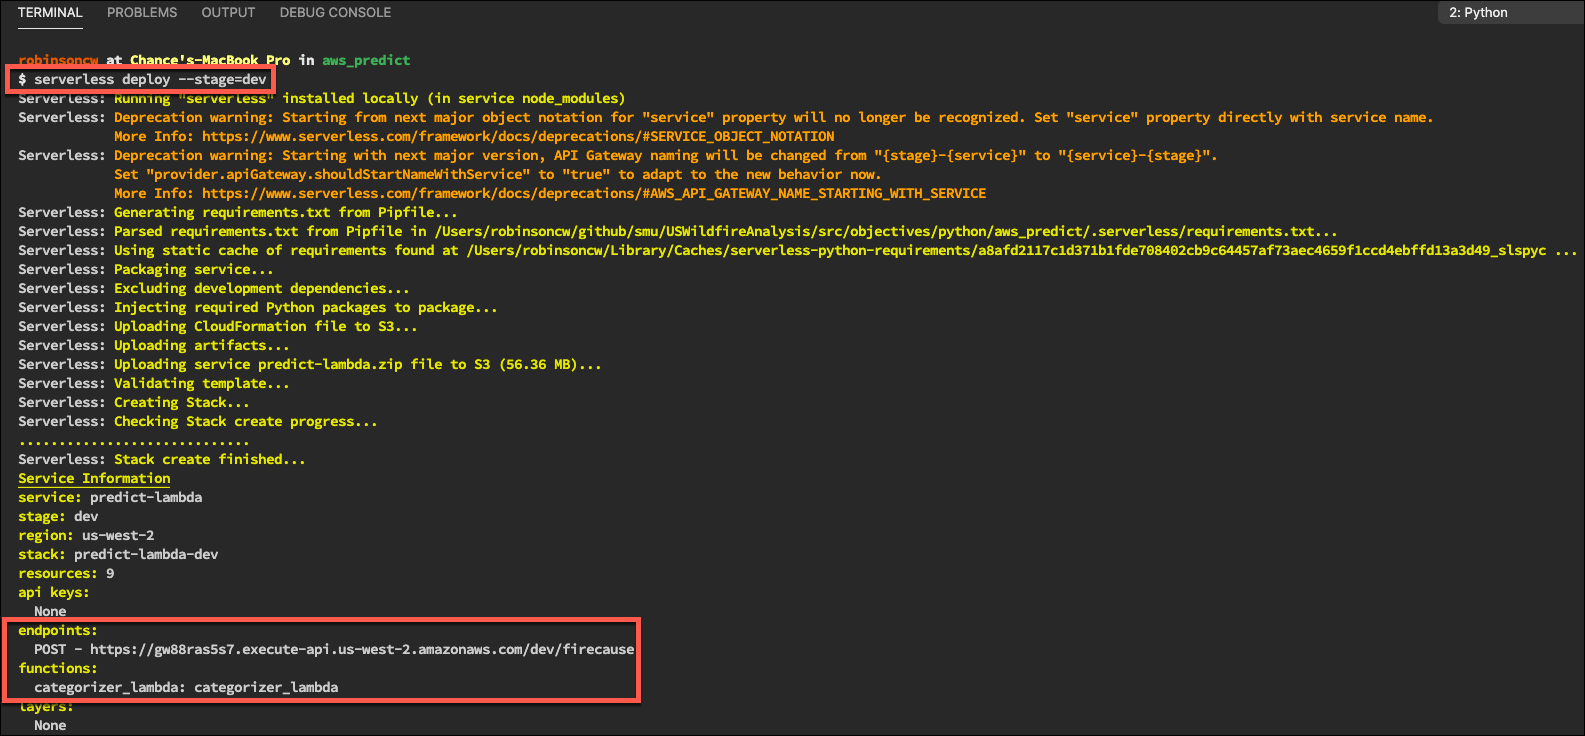

In [27]:
Image(filename='./img/sls_deployment.png') 

###  Prediction Output

Once deployed, a working URL endpoint will be retured which can be used to validate the solution via a `CURL` or other web service request.

Once testing has been performed, the service could be deployed to production environment and make available for use based on your requirements.

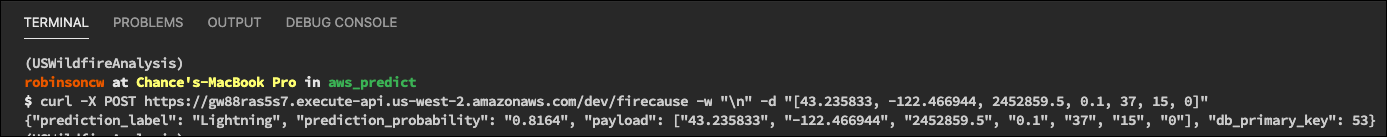

In [28]:
Image(filename='./img/aws_prediction_output.png') 

### CloudWatch Logging

Logging can be reviewed through the CloudWatch area from the AWS console.

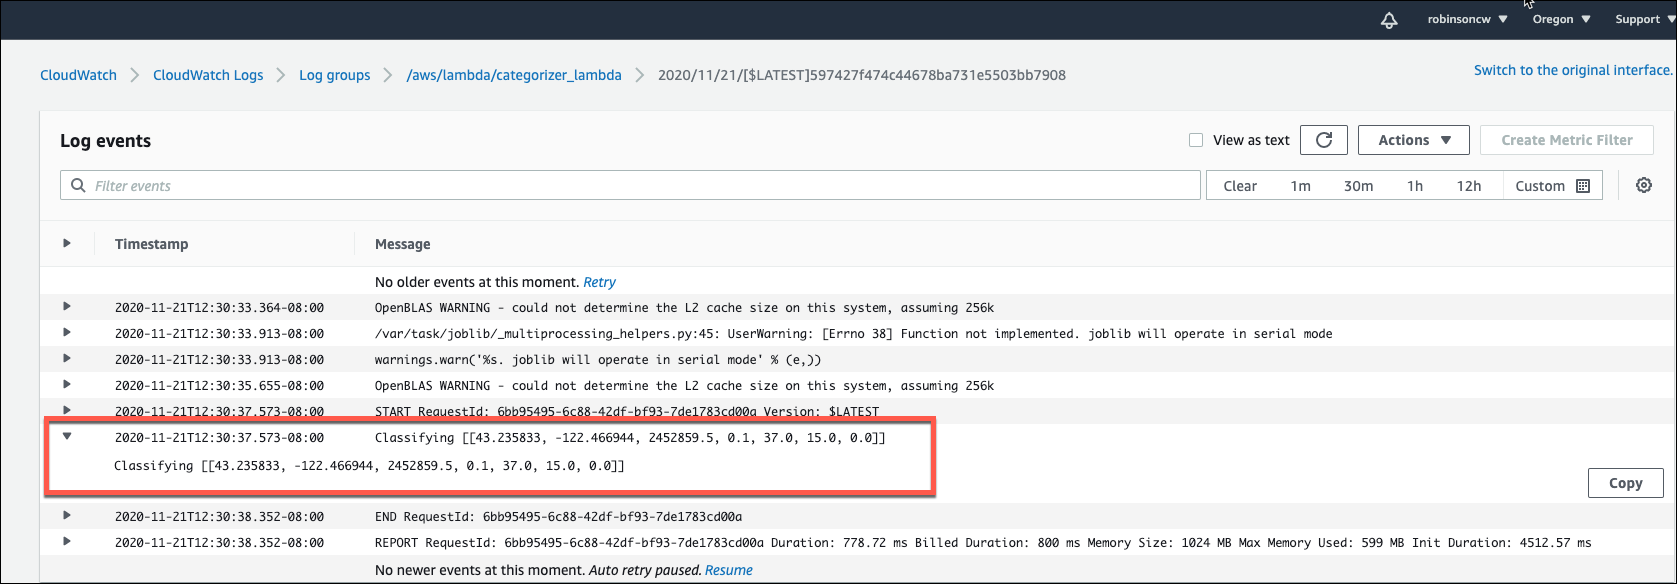

In [29]:
Image(filename='./img/aws_cloudwatch_logs.png') 

# Appendix

## Data Dictionary

This dataset is an SQLite database that contains the following information:

The source file can be found on [Kaggle | 1.88 Million US Wildfires](https://www.kaggle.com/rtatman/188-million-us-wildfires).

| Column Name | Data Type | Description |
|:---|:---|:---|
| **FOD_ID**                     | Integer | Global unique identifier. |
| **FPA_ID**                     | String | Unique identifier that contains information necessary to track back to the original record in the source dataset. |
| **SOURCESYSTEMTYPE**           | String | Type of source database or system that the record was drawn from (federal, nonfederal, or interagency). |
| **SOURCESYSTEM**               | String | Name of or other identifier for source database or system that the record was drawn from. See Table 1 in Short (2014), or \Supplements\FPAFODsourcelist.pdf, for a list of sources and their identifier. |
| **NWCGREPORTINGAGENCY**        | String | Active National Wildlife Coordinating Group (NWCG) Unit Identifier for the agency preparing the fire report (BIA = Bureau of Indian Affairs, BLM = Bureau of Land Management, BOR = Bureau of Reclamation, DOD = Department of Defense, DOE = Department of Energy, FS = Forest Service, FWS = Fish and Wildlife Service, IA = Interagency Organization, NPS = National Park Service, ST/C&L = State, County, or Local Organization, and TRIBE = Tribal Organization). |
| **NWCGREPORTINGUNIT_ID**       | String | Active NWCG Unit Identifier for the unit preparing the fire report. |
| **NWCGREPORTINGUNIT_NAME**     | String | Active NWCG Unit Name for the unit preparing the fire report. |
| **SOURCEREPORTINGUNIT**        | String | Code for the agency unit preparing the fire report, based on code/name in the source dataset. |
| **SOURCEREPORTINGUNIT_NAME**   | String | Name of reporting agency unit preparing the fire report, based on code/name in the source dataset. |
| **LOCALFIREREPORT_ID**         | String | Number or code that uniquely identifies an incident report for a particular reporting unit and a particular calendar year. |
| **LOCALINCIDENTID**            | String | Number or code that uniquely identifies an incident for a particular local fire management organization within a particular calendar year. |
| **FIRE_CODE**                  | String | Code used within the interagency wildland fire community to track and compile cost information for emergency fire suppression (https://www.firecode.gov/).|
| **FIRE_NAME**                  | String | Name of the incident, from the fire report (primary) or ICS-209 report (secondary). |
| **ICS209INCIDENT_NUMBER**      | String | Incident (event) identifier, from the ICS-209 report. |
| **ICS209NAME**                 | String | Name of the incident, from the ICS-209 report. |
| **MTBS_ID**                    | String | Incident identifier, from the MTBS perimeter dataset. |
| **MTBSFIRENAME**               | String | Name of the incident, from the MTBS perimeter dataset. |
| **COMPLEX_NAME**               | String | Name of the complex under which the fire was ultimately managed, when discernible. |
| **FIRE_YEAR**                  | Integer | Calendar year in which the fire was discovered or confirmed to exist. |
| **DISCOVERY_DATE**             | Float | Date on which the fire was discovered or confirmed to exist. |
| **DISCOVERY_DOY**              | Integer | Day of year on which the fire was discovered or confirmed to exist. |
| **DISCOVERY_TIME**             | String | Time of day that the fire was discovered or confirmed to exist. |
| **STATCAUSECODE**              | Float | Code for the (statistical) cause of the fire. |
| **STATCAUSEDESCR**             | String | Description of the (statistical) cause of the fire. |
| **CONT_DATE**                  | Float | Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year). |
| **CONT_DOY**                   | Float | Day of year on which the fire was declared contained or otherwise controlled. |
| **CONT_TIME**                  | String | Time of day that the fire was declared contained or otherwise controlled (hhmm where hh=hour, mm=minutes). |
| **FIRE_SIZE**                  | Float | Estimate of acres within the final perimeter of the fire. |
| **FIRESIZECLASS**              | String | Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres). |
| **LATITUDE**                   | Float | Latitude (NAD83) for point location of the fire (decimal degrees). |
| **LONGITUDE**                  | Float | Longitude (NAD83) for point location of the fire (decimal degrees). |
| **OWNER_CODE**                 | Float | Code for primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident. |
| **OWNER_DESCR**                | String | Name of primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident. |
| **STATE**                      | String | Two-letter alphabetic code for the state in which the fire burned (or originated), based on the nominal designation in the fire report. |
| **COUNTY**                     | String | County, or equivalent, in which the fire burned (or originated), based on nominal designation in the fire report. |
| **FIPS_CODE**                  | String | Three-digit code from the Federal Information Process Standards (FIPS) publication 6-4 for representation of counties and equivalent entities. |
| **FIPS_NAME**                  | String | County name from the FIPS publication 6-4 for representation of counties and equivalent entities. |

# References

[Kaggle | 1.88 Million US Wildfires](https://www.kaggle.com/rtatman/188-million-us-wildfires)